In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
# avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
train_data = tf.keras.utils.image_dataset_from_directory('data/train')

Found 1083 files belonging to 3 classes.


In [4]:
val_data = tf.keras.utils.image_dataset_from_directory('data/valid')

Found 150 files belonging to 3 classes.


In [5]:
test_data = tf.keras.utils.image_dataset_from_directory('data/test')

Found 600 files belonging to 3 classes.


In [6]:
class_names = train_data.class_names

In [7]:
class_counts = {class_name: 0 for class_name in class_names}

In [8]:
for images, labels in train_data:
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

In [9]:
class_distribution = list(class_counts.items())
class_labels, class_sizes = zip(*class_distribution)

In [10]:
df = pd.DataFrame({'Class': class_labels, 'Count': class_sizes})

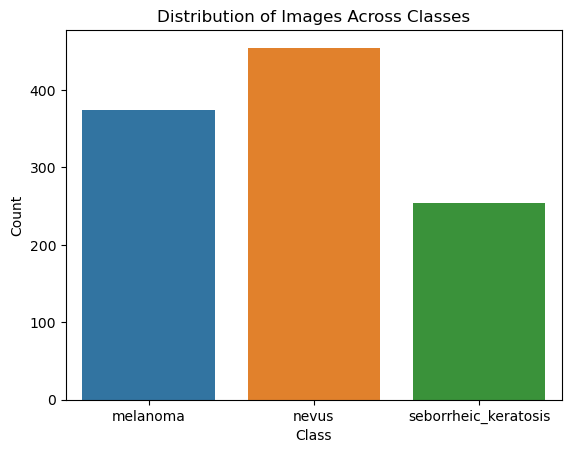

In [11]:
sns.barplot(x='Class', y='Count', data=df)
plt.title('Distribution of Images Across Classes')
plt.show()

In [12]:
train_data = train_data.map(lambda x, y: (x/255,y))
val_data = val_data.map(lambda x, y: (x/255, y))
test_data = test_data.map(lambda x, y: (x/255, y))

In [13]:
train_iterator = train_data.as_numpy_iterator()

In [14]:
batch = train_iterator.next()

In [15]:
batch[0].shape

(32, 256, 256, 3)

In [16]:
# 0 = melanoma, 1 = nevus, 2 = seborrheic keratosis
batch[1]

array([1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 1, 1, 0, 2, 0, 2, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 2, 1, 0, 2, 2, 0])

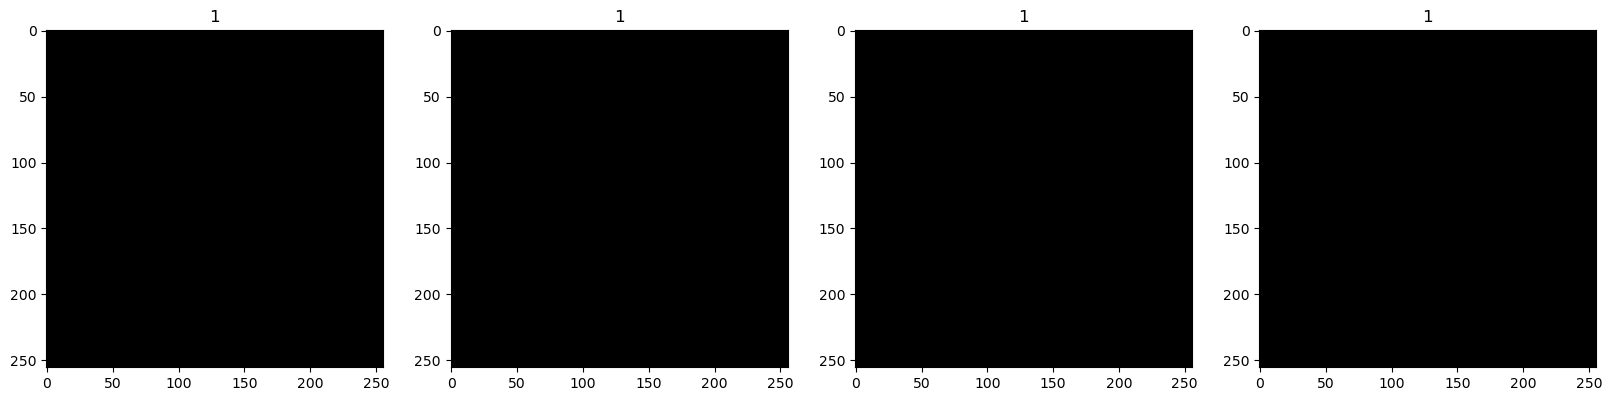

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [18]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


C:\Users\chloe\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,697,395 (14.10 MB)

 Trainable params: 3,697,267 (14.10 MB)

 Non-trainable params: 128 (512.00 B)

In [21]:
hist = model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4825 - loss: 10.5303 - val_accuracy: 0.5733 - val_loss: 6.1079
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5862 - loss: 6.7944 - val_accuracy: 0.2267 - val_loss: 7.4587
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6483 - loss: 5.3555 - val_accuracy: 0.2867 - val_loss: 7.0175
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7037 - loss: 4.2702 - val_accuracy: 0.5200 - val_loss: 7.3311
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7704 - loss: 3.4497 - val_accuracy: 0.5200 - val_loss: 7.0751
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7567 - loss: 3.0047 - val_accuracy: 0.5200 - val_loss: 8.6641
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7756 - loss: 2.5017 - val_accuracy: 0.3267 - val_loss: 7.2256
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7903 - loss: 2.3197 - val_accuracy: 0.2267 - val_loss

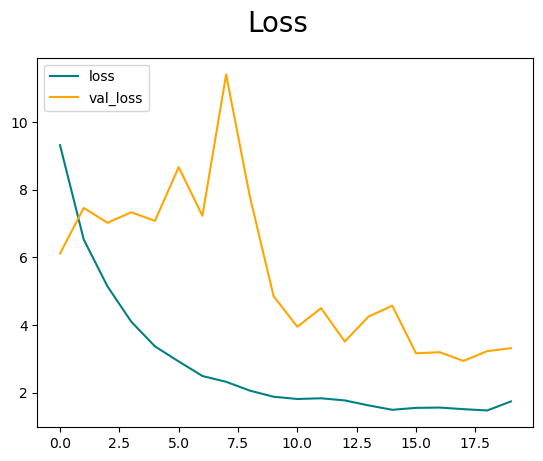

In [22]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

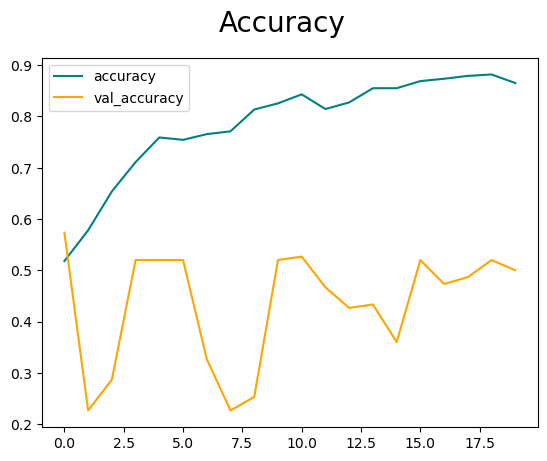

In [23]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [24]:
pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()

In [25]:
for batch in test_data.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat.argmax(axis=1))
    re.update_state(y, yhat.argmax(axis=1))
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


In [26]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8160377144813538, Recall:0.716356098651886, Accuracy:0.40666666626930237


In [29]:
img_path = 'images/sb.jpg'
img = image.load_img(img_path, target_size=(256, 256))

img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array /= 255.0

prediction = model.predict(img_array)

class_names = ['melanoma', 'nevus', 'seborrheic keratosis']

predicted_class = np.argmax(prediction, axis=1)
print(f"Predicted class: {predicted_class}")
print(f"Predicted class name: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: [0]
Predicted class name: melanoma
